## Import Libraries

In [1]:
# more common imports
import pandas as pd
import numpy as np
from collections import Counter
import re

# languange processing imports
import nltk
from gensim.corpora import Dictionary
# preprocessing imports
from sklearn.preprocessing import LabelEncoder

# model imports
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.word2vec import Word2Vec
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
# hyperparameter training imports
from sklearn.model_selection import GridSearchCV

# visualization imports
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import base64
import io
%matplotlib inline
sns.set()  # defines the style of the plots to be seaborn style

In [2]:
train_data = pd.read_csv('data/train.zip')

print(train_data.shape)
train_data.head(3)

(19579, 3)


,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP


## Feature Selection

In [3]:
# check if there's missing data
train_data.isnull().sum()

id        0
text      0
author    0
dtype: int64

In [4]:
# check if we indeed have three authors
train_data.author.value_counts().index

Index(['EAP', 'MWS', 'HPL'], dtype='object')

/home/Munachiso.Nwadike/anaconda3/envs/topic_lda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='author', ylabel='count'>

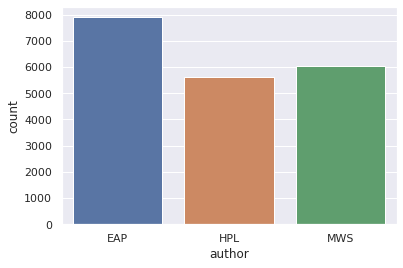

In [5]:
# value count for eavh author
sns.countplot(train_data['author'])

/home/Munachiso.Nwadike/anaconda3/envs/topic_lda/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Frequency distribution of number of words for each text extracted')

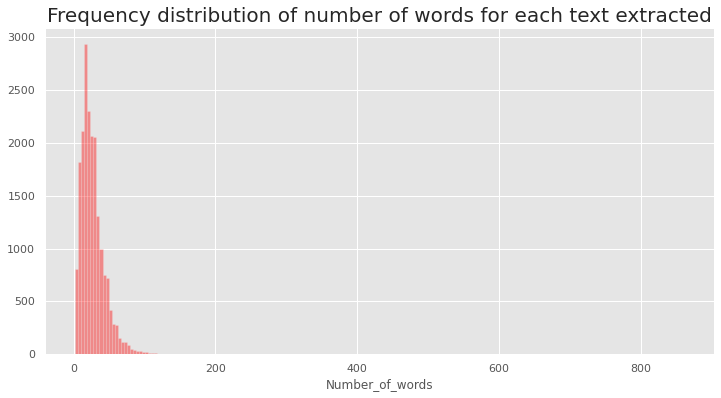

In [6]:
import matplotlib.pyplot as plt
train_data['Number_of_words'] = train_data['text'].apply(lambda x:len(str(x).split()))

plt.style.use('ggplot')
plt.figure(figsize=(12,6))
sns.distplot(train_data['Number_of_words'],kde = False,color="red",bins=200)
plt.title("Frequency distribution of number of words for each text extracted", size=20)

In [7]:
document_lengths = np.array(list(map(len, train_data.text.str.split(' '))))

print("The average number of words in a document is: {}.".format(np.mean(document_lengths)))
print("The minimum number of words in a document is: {}.".format(min(document_lengths)))
print("The maximum number of words in a document is: {}.".format(max(document_lengths)))

The average number of words in a document is: 26.730476530977068.
The minimum number of words in a document is: 2.
The maximum number of words in a document is: 861.


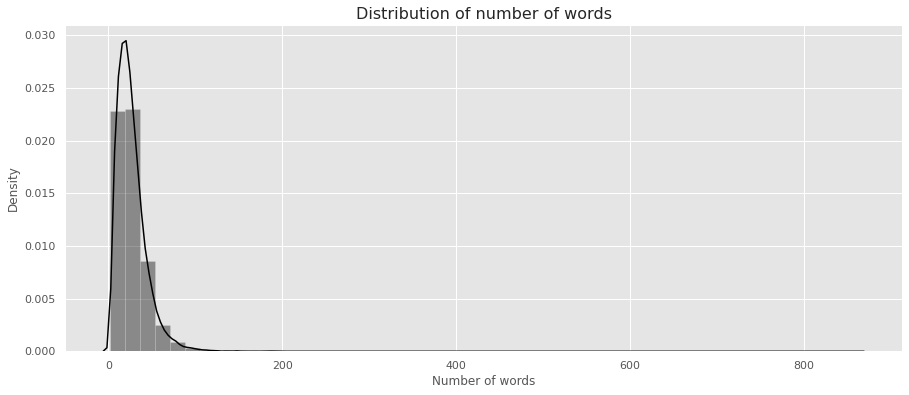

In [8]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title("Distribution of number of words", fontsize=16)
ax.set_xlabel("Number of words")
sns.distplot(document_lengths, color="black", bins=50, ax=ax);

There are 16 documents with over 150 words.


/home/Munachiso.Nwadike/anaconda3/envs/topic_lda/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


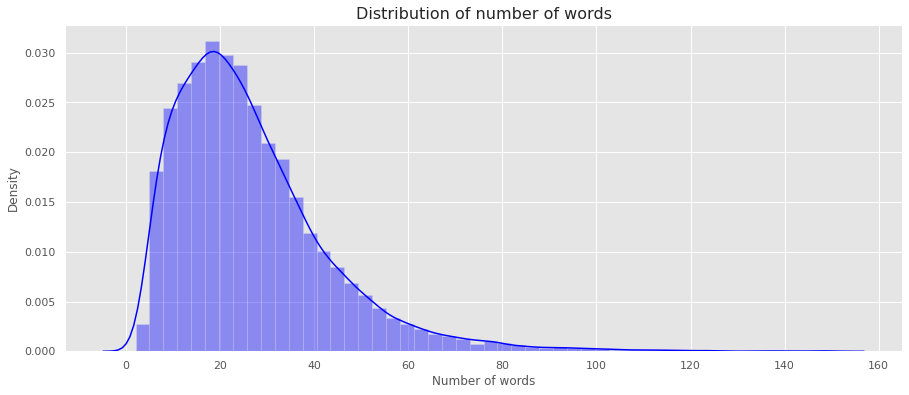

In [9]:
print("There are {} documents with over 150 words.".format(sum(document_lengths > 150)))
shorter_documents = document_lengths[document_lengths <= 150]

fig, ax = plt.subplots(figsize=(15,6))
ax.set_title("Distribution of number of words", fontsize=16)
ax.set_xlabel("Number of words")
sns.distplot(shorter_documents, bins=50, color="blue", ax=ax);

In [10]:
print("There are {} documents with tops 5 words.".format(sum(document_lengths <= 5)))
print(train_data[document_lengths == 2])
train_data[document_lengths == 3]

There are 452 documents with tops 5 words.
            id                     text author  Number_of_words
6936   id22015    "PIQUANT EXPRESSIONS.    EAP                2
9250   id23640  "EXTRAORDINARY MURDERS.    EAP                2
18064  id05139   Shakespeare's Sonnets.    MWS                2
18127  id20376    Shakspeare's Sonnets.    MWS                2


,id,text,author,Number_of_words
2403,id04385,"Yours everlastingly, PUNDITA.",EAP,3
2460,id04068,Distinguished several words.,EAP,3
2888,id13751,Everyone loved Elizabeth.,MWS,3
3076,id21984,This thought creates.,EAP,3
4016,id17846,The uproar increases.,EAP,3
4961,id17197,""" Odenheimer, restaurateur.",EAP,3
6394,id21456,Idris had disappeared.,MWS,3
6418,id27928,"""Sunday, the seventh.",EAP,3
8652,id26614,Cats they caterwauled.,EAP,3
8764,id16503,He dislikes children.,EAP,3


## Feature Selection

*(a) Text Tokenization*

In [11]:
# find and remove non-ascii words
# I stored our special word in a variable for later use
our_special_word = 'qwerty'

def remove_ascii_words(df):
    """ removes non-ascii characters from the 'texts' column in df.
    It returns the words containig non-ascii characers.
    """
    non_ascii_words = []
    for i in range(len(df)):
        for word in df.loc[i, 'text'].split(' '):
            if any([ord(character) >= 128 for character in word]):
                non_ascii_words.append(word)
                df.loc[i, 'text'] = df.loc[i, 'text'].replace(word, our_special_word)
    return non_ascii_words

non_ascii_words = remove_ascii_words(train_data)

print("Replaced {} words with characters with an ordinal >= 128 in the train data.".format(
    len(non_ascii_words)))

Replaced 240 words with characters with an ordinal >= 128 in the train data.


In [12]:
def get_good_tokens(sentence):
    replaced_punctation = list(map(lambda token: re.sub('[^0-9A-Za-z!?]+', '', token), sentence))
    removed_punctation = list(filter(lambda token: token, replaced_punctation))
    return removed_punctation

In [13]:
# Here we get transform the documents into sentences for the word2vecmodel
# we made a function such that later on when we make the submission, we don't need to write duplicate code
def w2v_preprocessing(df):
    """ All the preprocessing steps for word2vec are done in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    df['text'] = df.text.str.lower()
    df['document_sentences'] = df.text.str.split('.')  # split texts into individual sentences
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(map(nltk.word_tokenize, sentences)),
                                         df.document_sentences))  # tokenize sentences
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(map(get_good_tokens, sentences)),
                                         df.tokenized_sentences))  # remove unwanted characters
    df['tokenized_sentences'] = list(map(lambda sentences: list(filter(lambda lst: lst, sentences)), df.tokenized_sentences))  # remove empty lists

w2v_preprocessing(train_data)

In [14]:
print(train_data['tokenized_sentences'])
# print(lst)

0        [[this, process, however, afforded, me, no, me...
1        [[it, never, once, occurred, to, me, that, the...
2        [[in, his, left, hand, was, a, gold, snuff, bo...
3        [[how, lovely, is, spring, as, we, looked, fro...
4        [[finding, nothing, else, not, even, gold, the...
                               ...                        
19574    [[i, could, have, fancied, while, i, looked, a...
19575    [[the, lids, clenched, themselves, together, a...
19576    [[mais, il, faut, agir, that, is, to, say, a, ...
19577    [[for, an, item, of, news, like, this, it, str...
19578    [[he, laid, a, gnarled, claw, on, my, shoulder...
Name: tokenized_sentences, Length: 19579, dtype: object


In [15]:
def lda_get_good_tokens(df):
    df['text'] = df.text.str.lower()
    df['tokenized_text'] = list(map(nltk.word_tokenize, df.text))
    df['tokenized_text'] = list(map(get_good_tokens, df.tokenized_text))

lda_get_good_tokens(train_data)

In [16]:
tokenized_only_dict = Counter(np.concatenate(train_data.tokenized_text.values))
tokenized_only_df = pd.DataFrame.from_dict(tokenized_only_dict, orient='index')
tokenized_only_df.rename(columns={0: 'count'}, inplace=True)

In [17]:
tokenized_only_df.sort_values('count', ascending=False, inplace=True)

/home/Munachiso.Nwadike/anaconda3/envs/topic_lda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


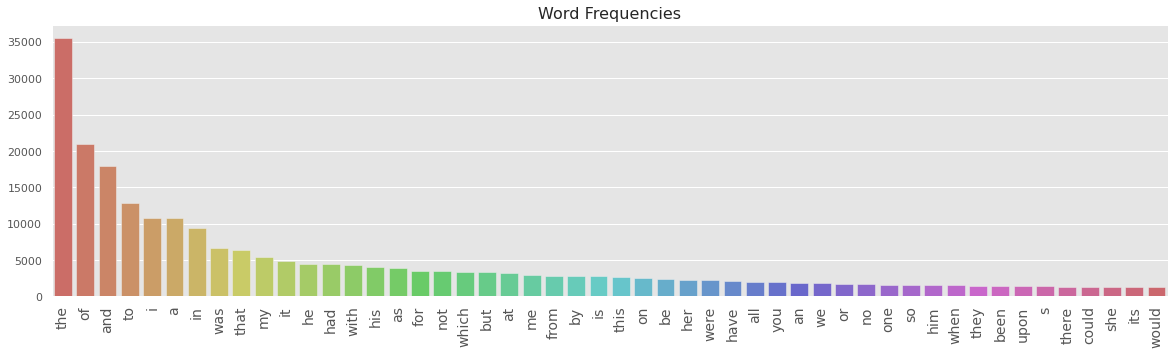

In [18]:
# I made a function out of this since I will use it again later on 
def word_frequency_barplot(df, nr_top_words=50):
    """ df should have a column named count.
    """
    fig, ax = plt.subplots(1,1,figsize=(20,5))

    sns.barplot(list(range(nr_top_words)), df['count'].values[:nr_top_words], palette='hls', ax=ax)

    ax.set_xticks(list(range(nr_top_words)))
    ax.set_xticklabels(df.index[:nr_top_words], fontsize=14, rotation=90)
    return ax
    
ax = word_frequency_barplot(tokenized_only_df)
ax.set_title("Word Frequencies", fontsize=16);

*(b) Remove words that mean little*

In [19]:
def remove_stopwords(df):
    """ Removes stopwords based on a known set of stopwords
    available in the nltk package. In addition, we include our
    made up word in here.
    """
    # Luckily nltk already has a set of stopwords that we can remove from the texts.
    stopwords = nltk.corpus.stopwords.words('english')
    # we'll add our own special word in here 'qwerty'
    stopwords.append(our_special_word)

    df['stopwords_removed'] = list(map(lambda doc:
                                       [word for word in doc if word not in stopwords],
                                       df['tokenized_text']))

remove_stopwords(train_data)

*(c) Word Stemming*

In [20]:
def stem_words(df):
    lemm = nltk.stem.WordNetLemmatizer()
    df['lemmatized_text'] = list(map(lambda sentence:
                                     list(map(lemm.lemmatize, sentence)),
                                     df.stopwords_removed))

    p_stemmer = nltk.stem.porter.PorterStemmer()
    df['stemmed_text'] = list(map(lambda sentence:
                                  list(map(p_stemmer.stem, sentence)),
                                  df.lemmatized_text))

stem_words(train_data)

*(d) Vectorize words*

In [21]:
dictionary = Dictionary(documents=train_data.stemmed_text.values)
print("Found {} words.".format(len(dictionary.values())))


dictionary.filter_extremes(no_above=0.8, no_below=3)
dictionary.compactify()  # Reindexes the remaining words after filtering
print("Left with {} words.".format(len(dictionary.values())))

Found 15352 words.
Left with 8246 words.


In [22]:
#Make a BOW for every document
def document_to_bow(df):
    df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), df.stemmed_text))
document_to_bow(train_data)

In [23]:
# Checking the effect of BOW out here
print( train_data.stemmed_text.head(5) )
print( train_data['bow'].head(5) )

0    [process, howev, afford, mean, ascertain, dime...
1           [never, occur, fumbl, might, mere, mistak]
2    [left, hand, gold, snuff, box, caper, hill, cu...
3    [love, spring, look, windsor, terrac, sixteen,...
4    [find, noth, els, even, gold, superintend, aba...
Name: stemmed_text, dtype: object
0    [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1...
1    [(10, 1), (21, 1), (22, 1), (23, 1), (24, 1), ...
2    [(26, 1), (27, 1), (28, 1), (29, 1), (30, 1), ...
3    [(43, 1), (44, 1), (45, 1), (46, 1), (47, 1), ...
4    [(30, 1), (52, 1), (62, 1), (63, 1), (64, 1), ...
Name: bow, dtype: object


In [24]:
# we make a function such that later on when we make the submission, we don't need to write duplicate code
def lda_preprocessing(df):
    """ All the preprocessing steps for LDA are combined in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    lda_get_good_tokens(df)
    remove_stopwords(df)
    stem_words(df)
    document_to_bow(df)

*(e) Visualize the cleansed words frequencies*

/home/Munachiso.Nwadike/anaconda3/envs/topic_lda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


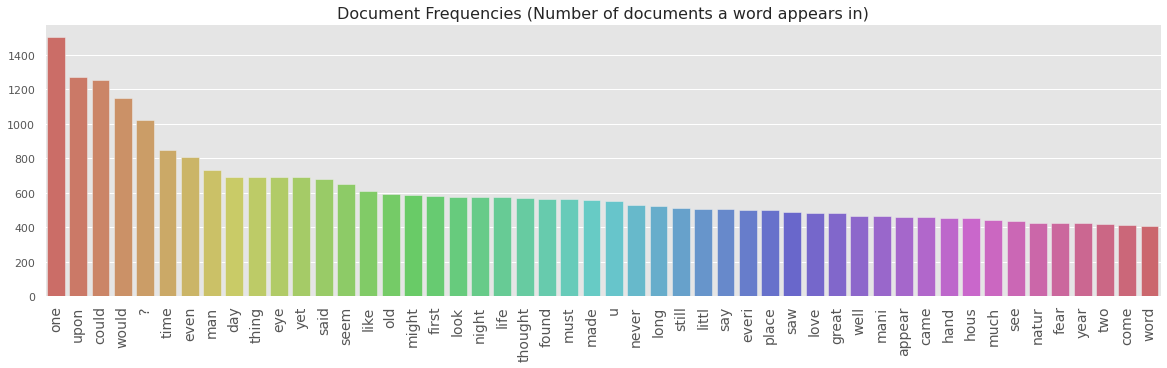

In [25]:
cleansed_words_df = pd.DataFrame.from_dict(dictionary.token2id, orient='index')
cleansed_words_df.rename(columns={0: 'id'}, inplace=True)

cleansed_words_df['count'] = list(map(lambda id_: dictionary.dfs.get(id_), cleansed_words_df.id))
del cleansed_words_df['id']

cleansed_words_df.sort_values('count', ascending=False, inplace=True)

ax = word_frequency_barplot(cleansed_words_df)
ax.set_title("Document Frequencies (Number of documents a word appears in)", fontsize=16);


/home/Munachiso.Nwadike/anaconda3/envs/topic_lda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/Munachiso.Nwadike/anaconda3/envs/topic_lda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/Munachiso.Nwadike/anaconda3/envs/topic_lda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an 

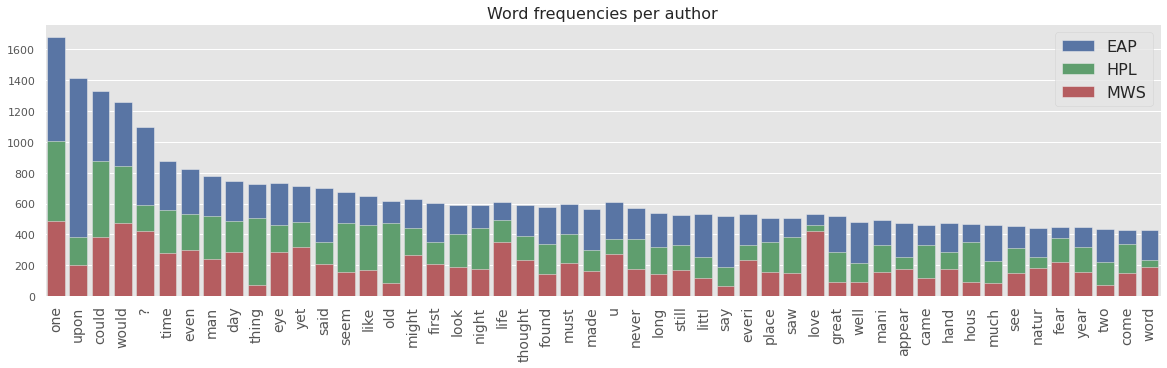

In [26]:
EAP_words = list(np.concatenate(train_data.loc[train_data.author == 'EAP', 'stemmed_text'].values))
HPL_words = list(np.concatenate(train_data.loc[train_data.author == 'HPL', 'stemmed_text'].values))
MWS_words = list(np.concatenate(train_data.loc[train_data.author == 'MWS', 'stemmed_text'].values))

EAP_word_frequencies = {word: EAP_words.count(word) for word in cleansed_words_df.index[:50]}
HPL_word_frequencies = {word: HPL_words.count(word) for word in cleansed_words_df.index[:50]}
MWS_word_frequencies = {word: MWS_words.count(word) for word in cleansed_words_df.index[:50]}

frequencies_df = pd.DataFrame(index=cleansed_words_df.index[:50])

frequencies_df['MWS_freq'] = list(map(lambda word: MWS_word_frequencies[word], frequencies_df.index))
frequencies_df['MWS_HPL_freq'] = list(map(lambda word: MWS_word_frequencies[word] + HPL_word_frequencies[word], frequencies_df.index))
frequencies_df['MWS_HPL_EAP_freq'] = list(map(lambda word: MWS_word_frequencies[word] + HPL_word_frequencies[word] + EAP_word_frequencies[word], frequencies_df.index))




fig, ax = plt.subplots(1,1,figsize=(20,5))
nr_top_words = len(frequencies_df)
nrs = list(range(nr_top_words))
sns.barplot(nrs, frequencies_df['MWS_HPL_EAP_freq'].values, color='b', ax=ax, label="EAP")
sns.barplot(nrs, frequencies_df['MWS_HPL_freq'].values, color='g', ax=ax, label="HPL")
sns.barplot(nrs, frequencies_df['MWS_freq'].values, color='r', ax=ax, label="MWS")

ax.set_title("Word frequencies per author", fontsize=16)
ax.legend(prop={'size': 16})
ax.set_xticks(nrs)
ax.set_xticklabels(frequencies_df.index, fontsize=14, rotation=90);

## Model Training

In [27]:
corpus = train_data.bow

num_topics = 150
#A multicore approach to decrease training time
LDAmodel = LdaMulticore(corpus=corpus,
                        id2word=dictionary,
                        num_topics=num_topics,
                        workers=4,
                        chunksize=4000,
                        passes=7,
                        alpha='asymmetric')


*(a) LDA topic inspection*

In [28]:
def document_to_lda_features(lda_model, document):
    """ Transforms a bag of words document to features.
    It returns the proportion of how much each topic was
    present in the document.
    """
    topic_importances = LDAmodel.get_document_topics(document, minimum_probability=0)
    topic_importances = np.array(topic_importances)
    return topic_importances[:,1]

train_data['lda_features'] = list(map(lambda doc:
                                      document_to_lda_features(LDAmodel, doc),
                                      train_data.bow))

/tmp/ipykernel_7335/3192477734.py:32: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout(h_pad=3.)


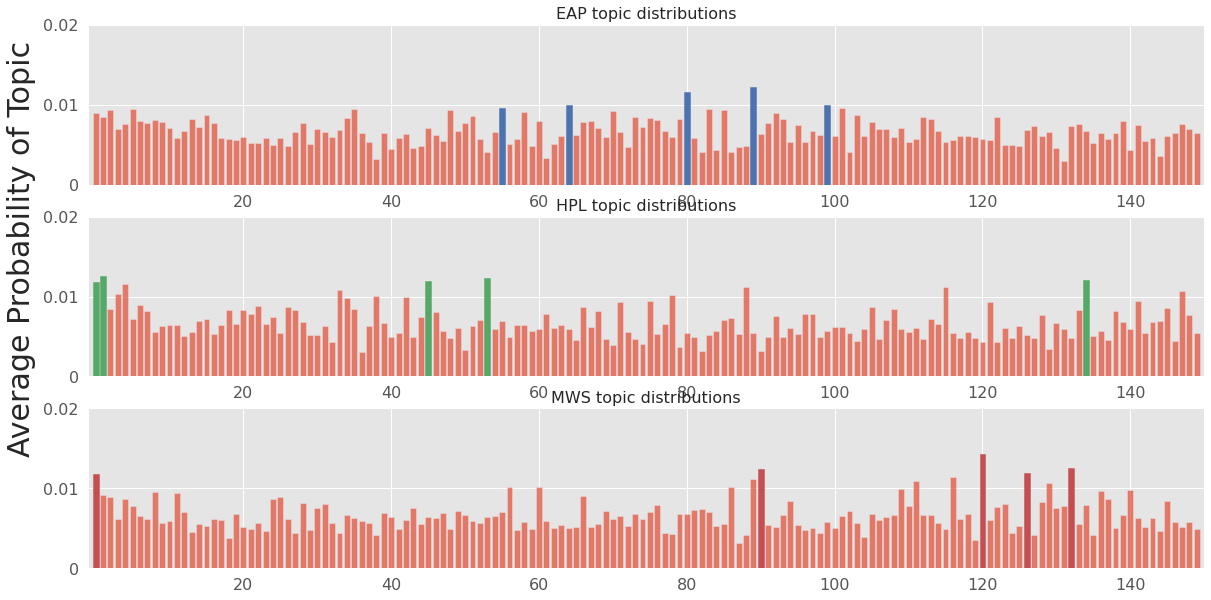

In [29]:
EAP_topic_distribution = train_data.loc[train_data.author == 'EAP', 'lda_features'].mean()
HPL_topic_distribution = train_data.loc[train_data.author == 'HPL', 'lda_features'].mean()
MWS_topic_distribution = train_data.loc[train_data.author == 'MWS', 'lda_features'].mean()

fig, [ax1,ax2,ax3] = plt.subplots(3,1,figsize=(20,10))

nr_top_bars = 5

ax1.set_title("EAP topic distributions", fontsize=16)
ax2.set_title("HPL topic distributions", fontsize=16)
ax3.set_title("MWS topic distributions", fontsize=16)
ax3.text(-10, 0.04, "Average Probability of Topic", fontsize=30, ha="center", va="center",
         rotation="vertical")

for ax, distribution, color in zip([ax1,ax2,ax3],
                                   [EAP_topic_distribution,HPL_topic_distribution,MWS_topic_distribution],
                                   ['b','g','r']):
    # Individual distribution barplots
    ax.bar(range(len(distribution)), distribution, alpha=0.7)
    rects = ax.patches
    for i in np.argsort(distribution)[-nr_top_bars:]:
        rects[i].set_color(color)
        rects[i].set_alpha(1)
    # General plotting adjustments
    ax.set_xlim(-1, 150)
    ax.set_xticks(range(20,149,20))
    ax.set_xticklabels(range(20,149,20), fontsize=16)
    ax.set_ylim(0,0.02)
    ax.set_yticks([0,0.01,0.02])
    ax.set_yticklabels([0,0.01,0.02], fontsize=16)

fig.tight_layout(h_pad=3.)

In [30]:
def get_topic_top_words(lda_model, topic_id, nr_top_words=5):
    """ Returns the top words for topic_id from lda_model.
    """
    id_tuples = lda_model.get_topic_terms(topic_id, topn=nr_top_words)
    word_ids = np.array(id_tuples)[:,0]
    words = map(lambda id_: lda_model.id2word[id_], word_ids)
    return words

In [31]:
for author, distribution in zip(['EAP', 'HPL', 'MWS'], [EAP_topic_distribution, HPL_topic_distribution, MWS_topic_distribution]):
    print("Looking up top words from top topics from {}.".format(author))
    for x in sorted(np.argsort(distribution)[-5:]):
        top_words = get_topic_top_words(LDAmodel, x)
        print("For topic {}, the top words are: {}.".format(x, ", ".join(top_words)))
    print("")

Looking up top words from top topics from EAP.
For topic 55, the top words are: question, dupin, paus, press, said.
For topic 64, the top words are: evid, one, utterli, box, departur.
For topic 80, the top words are: taken, perceiv, howev, mode, occur.
For topic 89, the top words are: ?, longer, think, dare, stage.
For topic 99, the top words are: done, former, art, greater, comprehend.

Looking up top words from top topics from HPL.
For topic 0, the top words are: could, day, everi, may, littl.
For topic 1, the top words are: old, around, would, love, life.
For topic 45, the top words are: god, stone, neither, difficulti, wood.
For topic 53, the top words are: shore, mile, whether, villag, tower.
For topic 134, the top words are: know, best, space, world, mother.

Looking up top words from top topics from MWS.
For topic 0, the top words are: could, day, everi, may, littl.
For topic 90, the top words are: endeavour, afterward, paint, cheer, endur.
For topic 120, the top words are: hope

In [32]:
def show_image(base64_encoded_image):
    """ Decodes a base64 encoded image and plots it.
    """
    fig, ax = plt.subplots(figsize=(10,10))

    decoded_image = base64.b64decode(base64_encoded_image)
    img = io.BytesIO(decoded_image)
    img = mpimg.imread(img, format='PNG')

    ax.imshow(img)
    ax.axis('off');

*(b) Word2Vec*

In [33]:
sentences = []
for sentence_group in train_data.tokenized_sentences:
    sentences.extend(sentence_group)

print("Number of sentences: {}.".format(len(sentences)))
print("Number of texts: {}.".format(len(train_data)))


# Set values for various parameters
num_features = 200    # Word vector dimensionality
min_word_count = 3    # Minimum word count
num_workers = 4       # Number of threads to run in parallel
context = 6           # Context window size
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model
W2Vmodel = Word2Vec(sentences=sentences,
                    sg=1,
                    hs=0,
                    workers=num_workers,
                    vector_size=num_features,
                    min_count=min_word_count,
                    window=context,
                    sample=downsampling,
                    negative=5,
                    epochs=6)

Number of sentences: 20510.
Number of texts: 19579.


In [34]:
def get_w2v_features(w2v_model, sentence_group):
    """ Transform a sentence_group (containing multiple lists
    of words) into a feature vector. It averages out all the
    word vectors of the sentence_group.
    """
    words = np.concatenate(sentence_group)  # words in text
    index2word_set = set(w2v_model.wv.index_to_key)  # words known to model
    
    featureVec = np.zeros(w2v_model.vector_size, dtype="float32")
    
    # Initialize a counter for number of words in a review
    nwords = 0
    # Loop over each word in the comment and, if it is in the model's vocabulary, add its feature vector to the total
    for word in words:
        if word in index2word_set: 
            featureVec = np.add(featureVec, w2v_model.wv[word])
            nwords += 1.

    # Divide the result by the number of words to get the average
    if nwords > 0:
        featureVec = np.divide(featureVec, nwords)
    return featureVec

train_data['w2v_features'] = list(map(lambda sen_group:
                                      get_w2v_features(W2Vmodel, sen_group),
                                      train_data.tokenized_sentences))

In [35]:
EAP_w2v_distribution = train_data.loc[train_data.author == 'EAP', 'w2v_features'].mean()
HPL_w2v_distribution = train_data.loc[train_data.author == 'HPL', 'w2v_features'].mean()
MWS_w2v_distribution = train_data.loc[train_data.author == 'MWS', 'w2v_features'].mean()

/tmp/ipykernel_7335/2903285181.py:23: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout(h_pad=3.)


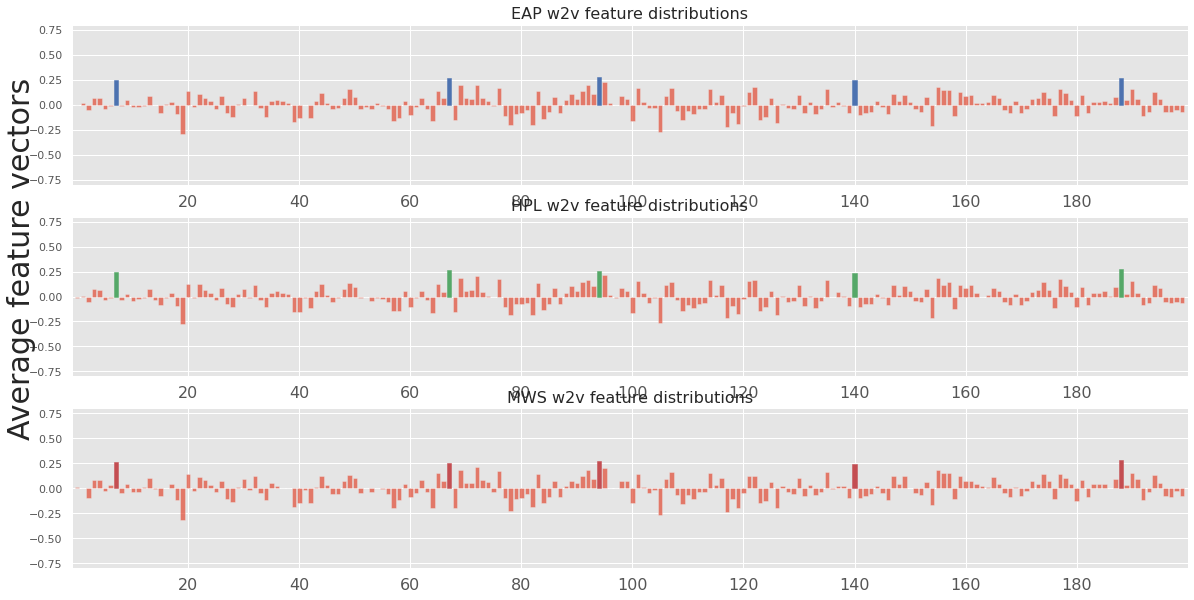

In [36]:
fig, [ax1,ax2,ax3] = plt.subplots(3,1,figsize=(20,10))

nr_top_bars = 5

ax1.set_title("EAP w2v feature distributions", fontsize=16)
ax2.set_title("HPL w2v feature distributions", fontsize=16)
ax3.set_title("MWS w2v feature distributions", fontsize=16)
ax3.text(-10, 2.3, "Average feature vectors", fontsize=30, ha="center", va="center", rotation="vertical")

for ax, distribution, color in zip([ax1,ax2,ax3], [EAP_w2v_distribution,HPL_w2v_distribution,MWS_w2v_distribution], ['b','g','r']):
    # Individual distribution barplots
    ax.bar(range(len(distribution)), distribution, alpha=0.7)
    rects = ax.patches
    for i in np.argsort(distribution)[-nr_top_bars:]:
        rects[i].set_color(color)
        rects[i].set_alpha(1)
    # General plotting adjustments
    ax.set_xlim(-1, 200)
    ax.set_xticks(range(20,199,20))
    ax.set_xticklabels(range(20,199,20), fontsize=16)
    ax.set_ylim(-0.8,0.8)

fig.tight_layout(h_pad=3.)

*(c) Classification and hyperparameter tuning*

In [37]:
label_encoder = LabelEncoder()

label_encoder.fit(train_data.author)
train_data['author_id'] = label_encoder.transform(train_data.author)

In [38]:
"""Note that there we take care to set return_train_score
See: https://stackoverflow.com/a/57136992/10702295
"""
def get_cross_validated_model(model, param_grid, X, y, nr_folds=5):
    """ Trains a model by doing a grid search combined with cross validation.
    args:
        model: your model
        param_grid: dict of parameter values for the grid search
    returns:
        Model trained on entire dataset with hyperparameters chosen from best results in the grid search.
    """
    # train the model (since the evaluation is based on the logloss, we'll use neg_log_loss here)
    grid_cv = GridSearchCV(model, param_grid=param_grid, scoring='neg_log_loss', cv=nr_folds, n_jobs=-1, verbose=True, return_train_score=True)
    best_model = grid_cv.fit(X, y)
    # show top models with parameter values
    result_df = pd.DataFrame(best_model.cv_results_)
    print("BLURGH!\n\n", result_df.head(5), "\n\n")
    show_columns = ['mean_test_score', 'mean_train_score', 'rank_test_score']
    for col in result_df.columns:
        if col.startswith('param_'):
            show_columns.append(col)
    display(result_df[show_columns].sort_values(by='rank_test_score').head())
    return best_model

In [39]:
# since train_data['lda_features'] and train_data['w2v_features'] don't have the needed shape and type yet,
# we first have to transform every entry
X_train_lda = np.array(list(map(np.array, train_data.lda_features)))
X_train_w2v = np.array(list(map(np.array, train_data.w2v_features)))
X_train_combined = np.append(X_train_lda, X_train_w2v, axis=1)

In [40]:
# store all models in a dictionary
models = dict()

*(d) Logistic Regression*

In [41]:
"""
Had to change linear regression solver parameter from lbfgs to liblinear
See error I was getting here: 
https://github.com/scikit-learn-contrib/sklearn-pandas/issues/197
"""

# LDA features only
lr = LogisticRegression() 

# param_grid = {'penalty': ['l1', 'l2']}

model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear','sag', 'saga']
penalty = ['l1', 'l2']
c_values = [5000, 1000, 100, 10, 1.0, 0.1, 0.01]

# define grid search
param_grid = dict(solver=solvers,penalty=penalty,C=c_values)

best_lr_lda = get_cross_validated_model(lr, param_grid, X_train_lda, train_data.author_id)
models['best_lr_lda'] = best_lr_lda

Fitting 5 folds for each of 70 candidates, totalling 350 fits


/home/Munachiso.Nwadike/anaconda3/envs/topic_lda/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
105 fits failed out of a total of 350.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/home/Munachiso.Nwadike/anaconda3/envs/topic_lda/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/Munachiso.Nwadike/anaconda3/envs/topic_lda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/Munachiso.Nwadike/anac

BLURGH!

    mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0       0.009058      0.000572         0.000000        0.000000    5000   
1       0.009387      0.000228         0.000000        0.000000    5000   
2       0.512953      0.030536         0.004509        0.000285    5000   
3       0.007808      0.001388         0.000000        0.000000    5000   
4       2.887151      0.126053         0.004215        0.000224    5000   

  param_penalty param_solver  \
0            l1    newton-cg   
1            l1        lbfgs   
2            l1    liblinear   
3            l1          sag   
4            l1         saga   

                                              params  split0_test_score  \
0  {'C': 5000, 'penalty': 'l1', 'solver': 'newton...                NaN   
1    {'C': 5000, 'penalty': 'l1', 'solver': 'lbfgs'}                NaN   
2  {'C': 5000, 'penalty': 'l1', 'solver': 'liblin...          -0.980777   
3      {'C': 5000, 'penalty': 'l1', 'solver': 

,mean_test_score,mean_train_score,rank_test_score,param_C,param_penalty,param_solver
47,-1.005617,-0.986089,1,1.0,l2,liblinear
42,-1.005815,-0.983677,2,1.0,l1,liblinear
37,-1.007857,-0.981548,3,10,l2,liblinear
46,-1.008067,-0.984319,4,1.0,l2,lbfgs
48,-1.008079,-0.984322,5,1.0,l2,sag


In [42]:
# Word2Vec features only
lr = LogisticRegression() # solver='liblinear'

# param_grid = {'penalty': ['l1', 'l2']}
best_lr_w2v = get_cross_validated_model(lr, param_grid, X_train_w2v, train_data.author_id)
models['best_lr_w2v'] = best_lr_w2v

Fitting 5 folds for each of 70 candidates, totalling 350 fits


/home/Munachiso.Nwadike/anaconda3/envs/topic_lda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/Munachiso.Nwadike/anaconda3/envs/topic_lda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/Munachiso.Nwadike/anaconda3/envs/topic_lda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/Munachiso.Nwadike/anaconda3/envs/topic_lda/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/Munachiso.Nwadike/anaconda3/envs/topic_lda/lib/python3.8/site-packages/sklearn/utils/optimize.py:203: UserWarnin

/home/Munachiso.Nwadike/anaconda3/envs/topic_lda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/Munachiso.Nwadike/anaconda3/envs/topic_lda/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/Munachiso.Nwadike/anaconda3/envs/topic_lda/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


/home/Munachiso.Nwadike/anaconda3/envs/topic_lda/lib/python3.8/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/home/Munachiso.Nwadike/anaconda3/envs/topic_lda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/Munachiso.Nwadike/anaconda3/envs/topic_lda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/Munachiso.Nwadike/anaconda3/envs/topic_lda/lib/python3.8

/home/Munachiso.Nwadike/anaconda3/envs/topic_lda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/Munachiso.Nwadike/anaconda3/envs/topic_lda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/Munachiso.Nwadike/anaconda3/envs/topic_lda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/Munachiso.Nwadike/anaconda3/envs/topic_lda/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/Munachiso.Nwadike/anaconda3/envs/topic_lda/lib/python3.8/site-packages/sklearn/utils/optimize.py:203: UserWarnin

BLURGH!

    mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0       0.004743      0.000342         0.000000        0.000000    5000   
1       0.004630      0.000627         0.000000        0.000000    5000   
2    1415.952298     61.222797         0.007057        0.000584    5000   
3       0.004677      0.000446         0.000000        0.000000    5000   
4      17.152512      0.125962         0.004781        0.000379    5000   

  param_penalty param_solver  \
0            l1    newton-cg   
1            l1        lbfgs   
2            l1    liblinear   
3            l1          sag   
4            l1         saga   

                                              params  split0_test_score  \
0  {'C': 5000, 'penalty': 'l1', 'solver': 'newton...                NaN   
1    {'C': 5000, 'penalty': 'l1', 'solver': 'lbfgs'}                NaN   
2  {'C': 5000, 'penalty': 'l1', 'solver': 'liblin...          -0.634726   
3      {'C': 5000, 'penalty': 'l1', 'solver': 

/home/Munachiso.Nwadike/anaconda3/envs/topic_lda/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/Munachiso.Nwadike/anaconda3/envs/topic_lda/lib/python3.8/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


,mean_test_score,mean_train_score,rank_test_score,param_C,param_penalty,param_solver
15,-0.623966,-0.595707,1,1000,l2,newton-cg
5,-0.624547,-0.593424,2,5000,l2,newton-cg
25,-0.630705,-0.609270,3,100,l2,newton-cg
7,-0.632081,-0.607279,4,5000,l2,liblinear
22,-0.632381,-0.609215,5,100,l1,liblinear


In [43]:
# LDA and Word2Vec combined
lr = LogisticRegression() # solver='liblinear'

# param_grid = {'penalty': ['l1', 'l2']}
best_lr_combined = get_cross_validated_model(lr, param_grid, X_train_combined, train_data.author_id)
models['best_lr_combined'] = best_lr_combined

Fitting 5 folds for each of 70 candidates, totalling 350 fits


/home/Munachiso.Nwadike/anaconda3/envs/topic_lda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/Munachiso.Nwadike/anaconda3/envs/topic_lda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/Munachiso.Nwadike/anaconda3/envs/topic_lda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number o

/home/Munachiso.Nwadike/anaconda3/envs/topic_lda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/Munachiso.Nwadike/anaconda3/envs/topic_lda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/Munachiso.Nwadike/anaconda3/envs/topic_lda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/Munachiso.Nwadike/anaconda3/envs/topic_lda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please

/home/Munachiso.Nwadike/anaconda3/envs/topic_lda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/Munachiso.Nwadike/anaconda3/envs/topic_lda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/Munachiso.Nwadike/anaconda3/envs/topic_lda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number o

/home/Munachiso.Nwadike/anaconda3/envs/topic_lda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/Munachiso.Nwadike/anaconda3/envs/topic_lda/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/Munachiso.Nwadike/anaconda3/envs/topic_lda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/Munachiso.Nwadike/anaconda3/envs/topic_lda/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
105 fits failed out of a total of 350.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more

BLURGH!

    mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0       0.022037      0.005132         0.000000        0.000000    5000   
1       0.020868      0.004231         0.000000        0.000000    5000   
2    2483.853583    117.969444         0.010725        0.005511    5000   
3       0.022149      0.004026         0.000000        0.000000    5000   
4      27.019271      0.362765         0.010335        0.006050    5000   

  param_penalty param_solver  \
0            l1    newton-cg   
1            l1        lbfgs   
2            l1    liblinear   
3            l1          sag   
4            l1         saga   

                                              params  split0_test_score  \
0  {'C': 5000, 'penalty': 'l1', 'solver': 'newton...                NaN   
1    {'C': 5000, 'penalty': 'l1', 'solver': 'lbfgs'}                NaN   
2  {'C': 5000, 'penalty': 'l1', 'solver': 'liblin...          -0.623420   
3      {'C': 5000, 'penalty': 'l1', 'solver': 

,mean_test_score,mean_train_score,rank_test_score,param_C,param_penalty,param_solver
15,-0.624787,-0.571939,1,1000,l2,newton-cg
5,-0.625865,-0.569657,2,5000,l2,newton-cg
25,-0.630263,-0.584775,3,100,l2,newton-cg
7,-0.631031,-0.584489,4,5000,l2,liblinear
22,-0.631064,-0.586488,5,100,l1,liblinear


## Model Selection

In [44]:
for name, model in models.items():
    print("Model {} has a test score of: {:0.4f}".format(name, float(model.best_score_)))

Model best_lr_lda has a test score of: -1.0056
Model best_lr_w2v has a test score of: -0.6240
Model best_lr_combined has a test score of: -0.6248


In [45]:
test_data = pd.read_csv('./data/test.csv')

print(test_data.shape)
print(test_data.head(3))

non_ascii_words = remove_ascii_words(test_data)

print("Replaced {} words with characters with an ordinal >= 128 in the test data.".format(
    len(non_ascii_words)))

lda_preprocessing(test_data)
w2v_preprocessing(test_data)

test_data['lda_features'] = list(map(lambda doc:
                                     document_to_lda_features(LDAmodel, doc),
                                     test_data.bow))

test_data['w2v_features'] = list(map(lambda sen_group:
                                     get_w2v_features(W2Vmodel, sen_group),
                                     test_data.tokenized_sentences))

train_data['author_id'] = label_encoder.transform(train_data.author)

X_test_lda = np.array(list(map(np.array, test_data.lda_features)))
X_test_w2v = np.array(list(map(np.array, test_data.w2v_features)))
X_test_combined = np.append(X_test_lda, X_test_w2v, axis=1)

(8392, 2)
        id                                               text
0  id02310  Still, as I urged our leaving Ireland with suc...
1  id24541  If a fire wanted fanning, it could readily be ...
2  id00134  And when they had broken down the frail door t...
Replaced 79 words with characters with an ordinal >= 128 in the test data.


In [46]:
submission_predictions = best_lr_combined.predict_proba(X_test_combined)

label_encoder.classes_  # exactly the order in which we need to submit the writers 


array(['EAP', 'HPL', 'MWS'], dtype=object)

In [47]:
result = np.append(test_data.id.values.reshape(-1,1), submission_predictions, axis=1)
submission_df = pd.DataFrame(data=result, columns=['id', 'EAP', 'HPL', 'MWS'])
submission_df.to_csv('submission.csv', index=False)

/home/Munachiso.Nwadike/anaconda3/envs/topic_lda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/Munachiso.Nwadike/anaconda3/envs/topic_lda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/Munachiso.Nwadike/anaconda3/envs/topic_lda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/Munachiso.Nwadike/anaconda3/envs/topic_lda/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/Munachiso.Nwadike/anaconda3/envs/topic_lda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached wh